In [10]:
import wandb
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [11]:
wandb.login()

True

In [12]:
api = wandb.Api()
runs = api.runs("fsoconut/generative-modelling", {"group": "MNIST-base"})

# Get summary metrics for each run
summaries = []
for run in runs:
    summaries.append(run.summary._json_dict)

print(f"Found {len(summaries)} runs")
print("\nSummary metrics:")
if len(summaries) > 0:
    for key in summaries[0].keys():
        print(f"- {key}")

Found 50 runs

Summary metrics:
- Training/acc
- Training/energy_fake
- Training/energy_real
- Training/l1
- Training/loss
- Training/loss_clf
- Training/loss_gen
- _runtime
- _step
- _timestamp
- _wandb
- batch
- epoch


In [13]:
# Convert list of summary dicts to dataframe
df = pd.DataFrame(summaries)
df.head()

,Training/acc,Training/energy_fake,Training/energy_real,Training/l1,Training/loss,Training/loss_clf,Training/loss_gen,_runtime,_step,_timestamp,_wandb,batch,epoch,Testing/acc
0,0.656250,129.795609,45.244324,1.070363,-83.436958,1.114325,-84.551285,153.371846,616,1.749116e+09,{'runtime': 154},616,1,NaN
1,0.578125,135.906082,38.095322,1.145959,-96.223640,1.587114,-97.810753,116.643087,454,1.749116e+09,{'runtime': 116},454,1,NaN
2,0.609375,141.951385,48.276695,1.282979,-92.368660,1.306033,-93.674690,101.452531,412,1.749117e+09,{'runtime': 101},412,1,NaN
3,0.421875,149.537659,48.674416,1.147568,-96.517769,4.345469,-100.863235,153.695486,609,1.749117e+09,{'runtime': 154},609,1,NaN
4,0.390625,160.652679,79.543037,0.938155,-78.788467,2.321184,-81.109650,296.199832,1223,1.749117e+09,{'runtime': 297},1222,2,0.86112


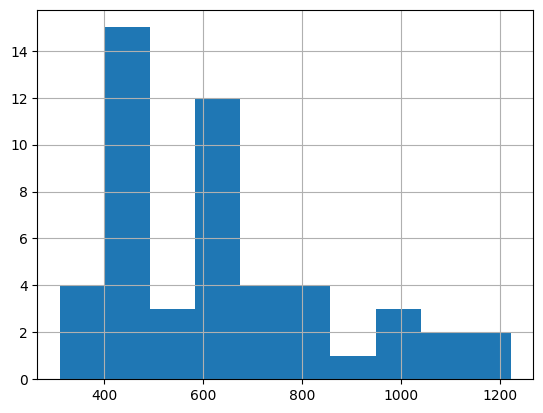

In [14]:
df['batch'].hist()
plt.show()

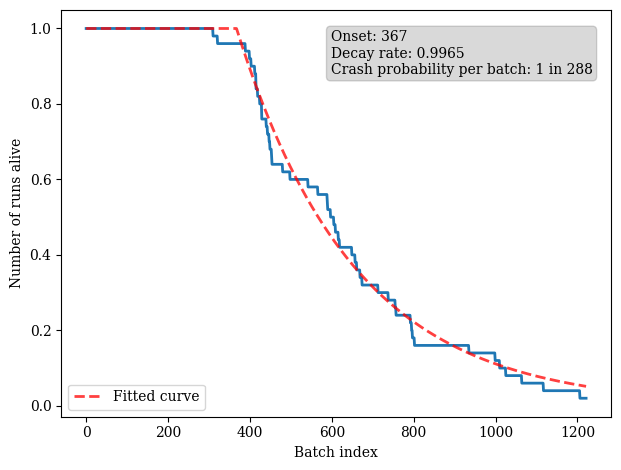

Onset: 367
Decay rate: 0.9965
Crash probability 1 in 288 batches


In [ ]:
alive = np.zeros(df['batch'].max())
for i, row in df.iterrows():
    alive[0:row['batch']] += 1
alive /= len(runs)
ax = plt.gca()

# Set font to serif globally for this plot
plt.rcParams['font.family'] = 'serif'

plt.plot(alive, linewidth=2, alpha=1.0)
plt.xlabel('Batch index')
plt.ylabel('Fraction of runs alive')

# Fit exponential decay
from scipy.optimize import curve_fit
def exp_decay(x, rate, onset):
    return np.where(x < onset, 1, rate ** (x - onset))

xs = np.arange(len(alive))
popt, _ = curve_fit(exp_decay, xs, alive)
plt.plot(xs, exp_decay(xs, *popt), label='Fitted curve', linestyle='--', color='red', linewidth=2, alpha=0.75)

# Add parameter information as text on the plot
info_text = f'Onset: {round(popt[1])}\nDecay rate: {popt[0]:.4f}\nCrash probability per batch: 1 in {round(1 / (1-popt[0]))}'
plt.text(0.49, 0.95, info_text, transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='black', alpha=0.15))

plt.legend()
plt.tight_layout()
plt.savefig('crash_distr.png', dpi=300)
plt.show()

print(f'Onset: {round(popt[1])}')
print(f'Decay rate: {popt[0]:.4f}')
print(f'Crash probability 1 in {round(1 / (1-popt[0]))} batches')
